In [1]:
import cv2
from matplotlib import pyplot as plt
# %tensorflow_version 2.x
import tensorflow
# tensorflow.__version__
import random

from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score
)
import tensorflow as tf
from keras import callbacks

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Initialize the random number generator
random.seed(1)

In [3]:
from tensorflow.keras.models import Sequential          # Sequential groups a linear stack of layers into a tf.keras.Model.
from tensorflow.keras.layers import Conv2D              # This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
from tensorflow.keras.layers import MaxPooling2D        # Max pooling operation for 2D spatial data.
from tensorflow.keras.layers import Flatten             # Flattens the input. Does not affect the batch size.
from tensorflow.keras.layers import Dense, Dropout      # Dropout: Applies Dropout to the input.
                                                        # Dense: Just your regular densely-connected NN layer.

In [4]:
import numpy as np                               # Import numpy
from skimage import data, io                     # Import skimage library (data - Test images and example data.
                                                 #                          io - Reading, saving, and displaying images.) 
import matplotlib.pyplot as plt                  # Import matplotlib.pyplot (Plotting framework in Python.)

import os                                        # This module provides a portable way of using operating system dependent functionality.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [5]:
# # From  https://www.tensorflow.org/tutorials/load_data/images

# import numpy as np
# import os
# import PIL
# import PIL.Image
# import tensorflow as tf
# import tensorflow_datasets as tfds

# import pathlib
# dataset_url = "https://olympus.mygreatlearning.com/courses/58531/files/4929964/download?verifier=c1Lp5f9eeJnuid9kIt5ZNXzhuTnPYJHJSAOgKr0B&wrap=1"
# data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                    fname='shapes_data',
#                                    untar=True)
# data_dir = pathlib.Path(data_dir)
# image_count = len(list(data_dir.glob('*/*.jpg')))
# print(image_count)




In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator    # Generate batches of tensor image data with real-time data augmentation.


# Create data generator for training data with data augmentation and normalizing all
# values by 255
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator(rescale = 1./255)

# Setting training data generator's source directory ("." means the current directory. 
# ("./dataset" means that dataset is inside current directory))
# Setting the target size to resize all the images to (64,64) as the model input layer expects 64X64 images

training_set = train_datagen.flow_from_directory('./shapes/Training',
                                                 target_size = (28, 28),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

# "./dataset/test" means that test is inside dataset inside current directory.
# Setting testing data generator's source directory
test_set = test_datagen.flow_from_directory('./shapes/Testing',
                                            target_size = (28, 28),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [7]:
# Initialising the CNN classifier
classifier = Sequential()

# Add a Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))

# Add a Max Pooling layer of size 2X2
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))

# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'valid'))

# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening the layer before fully connected layers
classifier.add(Flatten())

# Adding a fully connected layer with 512 neurons
classifier.add(Dense(units = 512, activation = 'relu'))

# Adding dropout with probability 0.5
classifier.add(Dropout(0.5))


# Adding a fully connected layer with 128 neurons
classifier.add(Dense(units = 128, activation = 'relu'))


# The final output layer with 3 neurons to predict the categorical classifcation
classifier.add(Dense(units = 3, activation = 'softmax'))

In [8]:
''' Compile model (using the efficient Adam gradient descent optimization algorithm
    with a logarithmic loss function, which is called “categorical_crossentropy” in Keras.)'''
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [9]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 32)          9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 32)         0

In [10]:
#adding earlystopping callback
es= callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0, 
    mode='min', 
    restore_best_weights= True
)

# #add class weights
# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(training_set), y=test_set)
# class_weights = dict(enumerate(class_weights))


In [11]:
# There are 240 training images and 60 test images in total
history = classifier.fit(
    training_set,
    steps_per_epoch = int(240/32),
    epochs = 100,
    validation_data = test_set,
    validation_steps = int(60/32),
    # validation_split=0.2, 
    batch_size=500, 
    callbacks=[es], 
    verbose=1,
    # class_weight=class_weights
)

Epoch 1/100
7/7 [==============================] - 1s 114ms/step - loss: 1.1112 - accuracy: 0.2837 - val_loss: 1.1003 - val_accuracy: 0.3125
Epoch 2/100
7/7 [==============================] - 0s 62ms/step - loss: 1.1130 - accuracy: 0.3348 - val_loss: 1.1029 - val_accuracy: 0.3438
Epoch 3/100
7/7 [==============================] - 0s 52ms/step - loss: 1.0955 - accuracy: 0.3221 - val_loss: 1.1076 - val_accuracy: 0.3125
Epoch 4/100
7/7 [==============================] - 0s 62ms/step - loss: 1.1027 - accuracy: 0.3269 - val_loss: 1.1085 - val_accuracy: 0.3438
Epoch 5/100
7/7 [==============================] - 0s 58ms/step - loss: 1.1025 - accuracy: 0.3077 - val_loss: 1.0964 - val_accuracy: 0.3438
Epoch 6/100
7/7 [==============================] - 0s 60ms/step - loss: 1.0991 - accuracy: 0.3438 - val_loss: 1.0950 - val_accuracy: 0.4375
Epoch 7/100
7/7 [==============================] - 0s 62ms/step - loss: 1.0987 - accuracy: 0.3214 - val_loss: 1.0986 - val_accuracy: 0.3125
Epoch 8/100
7/7 [==

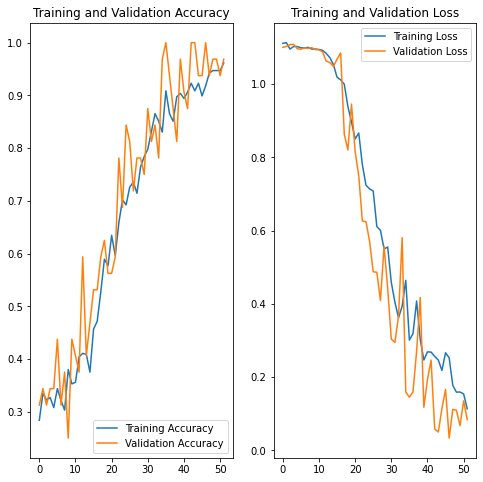

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()